In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Load Dataset

In [2]:
df = pd.read_csv('s_aes_Quadruplets.csv')
number_of_rows = 100000 

In [3]:
#! reshaping data and converting it into integers
pt= df['plaintext'].head(number_of_rows)
ct= df['ciphertext'].head(number_of_rows)
before_xor = df['before_xor'].head(number_of_rows)
iv = df['iv'].head(number_of_rows)
data=pt + ct + before_xor + iv
print(data.head())
data = data.apply(lambda x: np.array(list(x)).reshape(4, 4))
data = data.apply(lambda arr: np.vectorize(lambda x: int(x, 16))(arr))
data = np.stack(data.values)
data = data.reshape(number_of_rows, 4, 4, 1)
print(data.shape)

0    8d54a26b2f3fa56d
1    82823db3bf31a56d
2    b87c874e3f32a56d
3    b232d81a6a28a56d
4    afb1659dca2ca56d
dtype: object
(100000, 4, 4, 1)


In [4]:
#! getting labels
keys = df['key'].head(number_of_rows)
# ivs = df['iv'].head(number_of_rows)
keys_bits = keys.apply(lambda x: format(int(x, 16), '016b'))
# ivs_bits = ivs.apply(lambda x: format(int(x, 16), '0128b'))
labels = keys_bits 
print("Length:", len(labels.iloc[0]))
print(labels.head())

Length: 16
0    0010010111000010
1    0010010111000010
2    0010010111000010
3    0010010111000010
4    0010010111000010
Name: key, dtype: object


In [5]:
def preprocess_labels(labels):
    return np.array([list(map(int, label)) for label in labels], dtype=np.float32)

labels_array = preprocess_labels(labels)
print("Labels shape:", labels_array.shape)

Labels shape: (100000, 16)


# Model

In [6]:
#! residual connetions block
def residual_block(x, filters, kernel_size):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [7]:
class AllToAllLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(AllToAllLayer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True,name='AllToAllKernelW1')
        self.bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True,
            name='AllToAllKernelBias1'
        )
   
        super(AllToAllLayer, self).build(input_shape)

    def call(self, inputs):
        
        return  tf.matmul(inputs, self.kernel) + self.bias

In [8]:
def create_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    
    # Apply multiple residual blocks
    for _ in range(10):  # Adjust the number of blocks as needed
        x = residual_block(x, 64, (3, 3))
    
    # Global Average Pooling
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Fully connected layer
    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Output layer (assuming binary classification, adjust as needed)
    x = AllToAllLayer(16)(x)
    
    # Output layer
    outputs = layers.Activation('sigmoid')(x)    
    # Create the model
    model = models.Model(inputs, outputs)
    return model


In [9]:
def custom_binary_crossentropy(y_true, y_pred):
    print("y_true shape:", tf.shape(y_true))
    print("y_pred shape:", tf.shape(y_pred))
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [10]:
input_shape = (4, 4, 1)
model = create_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=custom_binary_crossentropy,
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 4, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 4, 4, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 4, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 4, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 4, 64)  │          0 │ batch_normalizat

 Total params: 2,759,952 (10.53 MB)

 Trainable params: 2,751,504 (10.50 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [12]:
history = model.fit(data, labels_array, epochs=300, batch_size=128)

Epoch 1/300
y_true shape: Tensor("compile_loss/custom_binary_crossentropy/Shape:0", shape=(2,), dtype=int32)
y_pred shape: Tensor("compile_loss/custom_binary_crossentropy/Shape_1:0", shape=(2,), dtype=int32)
y_true shape: Tensor("compile_loss/custom_binary_crossentropy/Shape:0", shape=(2,), dtype=int32)
y_pred shape: Tensor("compile_loss/custom_binary_crossentropy/Shape_1:0", shape=(2,), dtype=int32)
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.0658 - loss: 0.8721
Epoch 2/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.0629 - loss: 0.8548
Epoch 3/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.0656 - loss: 0.8423
Epoch 4/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.0659 - loss: 0.8315
Epoch 5/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.0674 - loss: 0.8220
Epoch 6/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.0673 - loss: 0.8129
Epoch 7/300
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.0686 

# Analysis

In [13]:
#! plot accuracy vs epochs
epochs = history.epoch
accuracy = history.history['accuracy']
loss = history.history['loss']

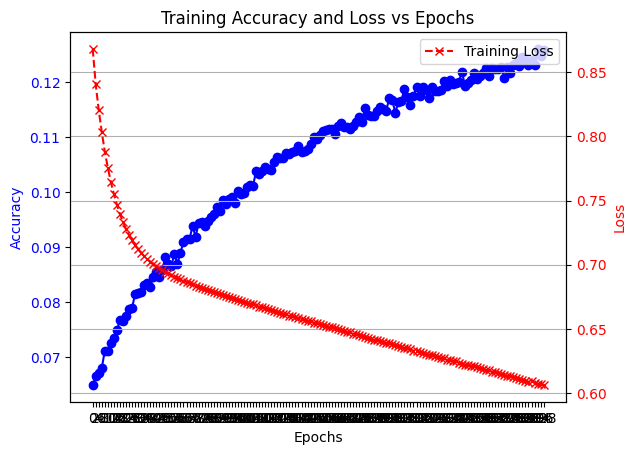

In [14]:
interval = 2
max_epoch = len(accuracy)  # or specify the total number of epochs used

# Generate epochs starting from 0 and incrementing by interval
epochs_to_plot = list(range(0, max_epoch, interval))
accuracy_to_plot = [accuracy[i] for i in epochs_to_plot if i < len(accuracy)]
loss_to_plot = [loss[i] for i in epochs_to_plot if i < len(loss)]  
# Plot
# Plot accuracy
plt.plot(epochs_to_plot, accuracy_to_plot, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', color='b')
plt.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for loss
ax2 = plt.gca().twinx()
ax2.plot(epochs_to_plot, loss_to_plot, marker='x', linestyle='--', color='r', label='Training Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add titles and legends
plt.title('Training Accuracy and Loss vs Epochs')
plt.grid(True)
plt.xticks(np.arange(0, max(epochs_to_plot) + interval, interval))
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [15]:
predictions = model.predict(data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step


<Figure size 800x600 with 0 Axes>

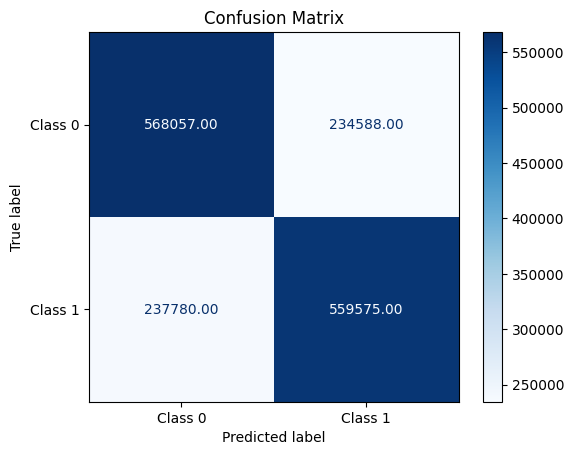

In [16]:
#! Hamming Accuracy Calculations
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = labels_array.flatten()

# Compute the confusion matrix for binary classification
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

In [17]:
#! F1 Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7048


In [18]:
hamming_distance = np.sum(predicted_classes != true_classes)

# Total number of bits
total_bits = len(true_classes)

# Calculate Hamming accuracy
hamming_accuracy = 1 - (hamming_distance / total_bits)

print(f"Hamming Accuracy: {hamming_accuracy:.4f}")

Hamming Accuracy: 0.7048


In [20]:
if model is None:
    raise ValueError("Model is not initialized.")
file_path = 'models/test_checkpoint.h5'


# Save the model
model.save(file_path)
